In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import Ridge, LinearRegression
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv("owid-covid-dat.csv", parse_dates=['date'])

In [3]:
data_russia = data[data.location=='Russia']
data_russia = data_russia[data_russia.date >= datetime(2020,3,5)]

In [4]:
train_russia_days = 50
all_russia_days = len(data_russia)
train_idx = range(train_russia_days)

In [5]:
def create_x_array(days_amount):
    return np.array([[1, i] for i in range(days_amount)])

In [6]:
x_train = create_x_array(train_russia_days)
x_all = create_x_array(all_russia_days)

In [7]:
total_cases = np.array(data_russia.total_cases)
new_cases = np.array(data_russia.new_cases)
new_cases = np.array([1 if k == 0 else k for k in new_cases])

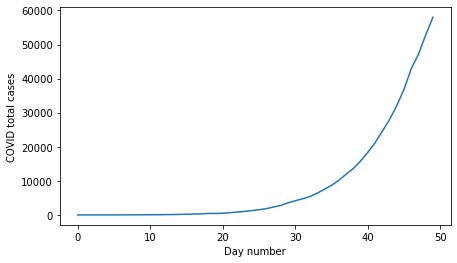

In [8]:
plt.figure(figsize=(7,4))
plt.plot(range(train_russia_days), total_cases[train_idx])
plt.xlabel("Day number")
plt.ylabel("COVID total cases")
plt.show()

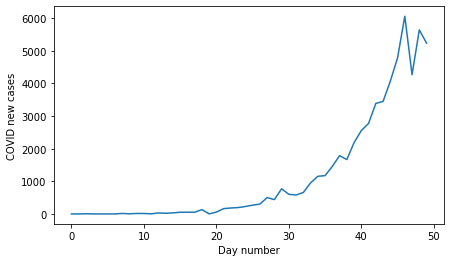

In [9]:
plt.figure(figsize=(7,4))
plt.plot(range(train_russia_days), new_cases[train_idx])
plt.xlabel("Day number")
plt.ylabel("COVID new cases")
plt.show()

#### Обученим линейную модель с экспоненциальным ростом

In [10]:
total_cases_log = np.log(total_cases)

In [11]:
model = Ridge()
model.fit(x_train, total_cases_log[train_idx])
print(model.coef_)

[0.        0.1977661]


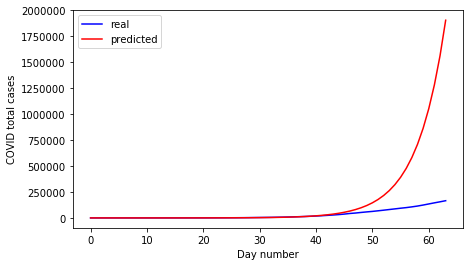

In [12]:
plt.figure(figsize=(7,4))
plt.plot(range(all_russia_days), total_cases, color='b', label='real')
plt.plot(range(all_russia_days), np.exp(model.predict(x_all)), color='r', label='predicted')
plt.xlabel("Day number")
plt.ylabel("COVID total cases")
plt.legend()
plt.show()

#### По графику можно сказать, что ошибка довольно большая (начиная с ~44 дня)

#### Найдём апостериорное распределение параметров

In [13]:
noise_variance = np.sum(np.power(total_cases_log[train_idx] - model.predict(x_train),2))/train_russia_days
print(noise_variance)

0.14472222986433025


In [14]:
nu_prior = np.array([0, 0])
sigma_prior = np.array([[1,0],[0,1]])

In [15]:
def calc_posterior(x, y, nu_prior, sigma_prior, noise_variance):
    sigma = np.linalg.inv(np.linalg.inv(sigma_prior) + np.matmul(np.transpose(x), x)/noise_variance)
    nu = np.matmul(sigma, np.matmul(np.linalg.inv(sigma_prior),nu_prior) + 
                   np.matmul(np.transpose(x), np.array(y))/noise_variance)
    return nu, sigma

In [16]:
nu_posterior, sigma_posterior = calc_posterior(x_train, total_cases_log[:train_russia_days], nu_prior, sigma_prior, noise_variance)

In [17]:
print(nu_posterior)

[1.97856174 0.19845608]


In [18]:
print(sigma_posterior)

[[ 1.11122694e-02 -3.36734231e-04]
 [-3.36734231e-04  1.37840363e-05]]


In [19]:
def plot_heatmap(nu, sigma):
    # Рисовать heatmap будем в пределах 4х стандартных отклонений
    plt.figure(figsize=(7,4))
    x_min = nu[0] - 4*sigma[0][0]**0.5
    x_max = nu[0] + 4*sigma[0][0]**0.5
    y_min = nu[1] - 4*sigma[1][1]**0.5
    y_max = nu[1] + 4*sigma[1][1]**0.5
    N = 250
    X = np.linspace(x_min, x_max, N)
    Y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))
    plt.pcolormesh(X, Y, multivariate_normal.pdf(pos,mean=nu, cov=sigma), cmap=plt.cm.jet)
    plt.show()

#### Апостериорное распределение

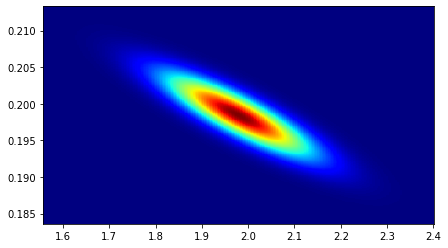

In [20]:
plot_heatmap(nu_posterior, sigma_posterior)

In [21]:
may1 = (datetime(2020,5,1) - datetime(2020,3,5)).days
jun1 = (datetime(2020,6,1) - datetime(2020,3,5)).days
sep1 = (datetime(2020,9,1) - datetime(2020,3,5)).days

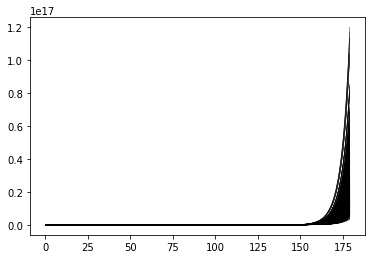

In [22]:
cases = np.zeros(3)
samples_num=1000
for i in range(samples_num):
    w = np.random.multivariate_normal(nu_posterior, sigma_posterior)
    cases[0] += np.e**(w[0]+w[1]*may1)/samples_num
    cases[1] += np.e**(w[0]+w[1]*jun1)/samples_num
    cases[2] += np.e**(w[0]+w[1]*sep1)/samples_num
    plt.plot(range(180), [np.e**(w[0]+w[1]*i) for i in range(180)], 'k-', lw=.4)
plt.show()

In [23]:
print("Случаев болезни 1 мая: ", int(cases[0]))
print("Случаев болезни 1 июня: ", int(cases[1]))
print("Случаев болезни 1 сентября: ", int(cases[2]))

Случаев болезни 1 мая:  593796
Случаев болезни 1 июня:  283281528
Случаев болезни 1 сентября:  27454548467159212


#### Очень пессиместичные числа. Построим предсказательное распределение

In [24]:
def sample_predictions(x, nu, sigma, n=100):
    w = np.random.multivariate_normal(nu, sigma, n)
    res = np.zeros((n, x.shape[0]))
    for i, w_cur in enumerate(w):
        res[i,:]= np.exp(np.matmul(x, w_cur))
    return res

In [25]:
def plot_dist(x, y, nu, sigma, plot_variance=True):
    plt.figure(figsize=(14,8))
    plt.plot(range(len(x)), np.exp(np.matmul(x, nu)), color='red')
    if plot_variance:
        plt.fill_between(range(len(x)), np.mean(y, axis=0)+np.std(y, axis=0), np.mean(y, axis=0)-np.std(y, axis=0))

In [26]:
y = sample_predictions(create_x_array(70), nu_posterior, sigma_posterior)

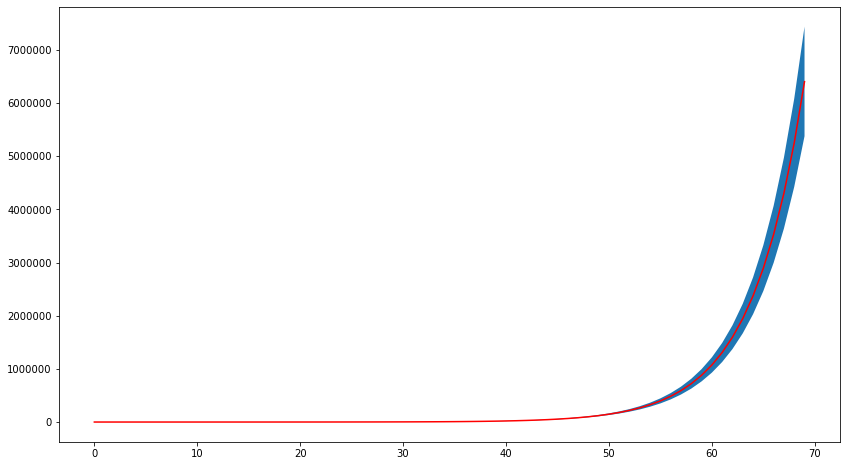

In [27]:
plot_dist(create_x_array(70), y, nu_posterior, sigma_posterior)

#### Теперь попробуем использовать F(x)=$\int_{-\infty}^xe^{at^2+bt+c}dt$. Напрямую обучать такую функцию линейной регрессией неполучится, но можно пробовать обчать её производные (кол-во новых случаев каждый день).
#### F'(x)=$e^{ax^2+bx+c}$.

In [28]:
def create_x_array_2(days_amount):
    return np.array([[1, i, i**2] for i in range(days_amount)])

In [29]:
x_train_2 = create_x_array_2(train_russia_days)
x_all_2 = create_x_array_2(all_russia_days)

In [30]:
new_cases_log = np.log(new_cases)

In [31]:
model2 = Ridge()
model2.fit(x_train_2, new_cases_log[:train_russia_days])
print(model2.coef_)

[ 0.          0.27475178 -0.00180319]


In [32]:
total_predicted = []
cur_total = 0
for i in range(180):
    cur_predicted = np.e**(model2.predict([[1,i,i**2]])[0])
    cur_total += cur_predicted
    total_predicted.append(cur_total)

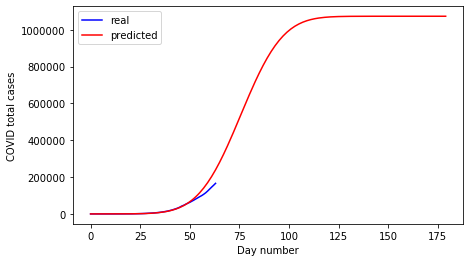

In [33]:
plt.figure(figsize=(7,4))
plt.plot(range(all_russia_days), total_cases, color='b', label='real')
plt.plot(range(180), total_predicted, color='r', label='predicted')
plt.xlabel("Day number")
plt.ylabel("COVID total cases")
plt.legend()
plt.show()

In [34]:
noise_variance_2 = np.sum(np.power(new_cases_log[train_idx] - model2.predict(x_train_2),2))/train_russia_days
print(noise_variance_2)

0.609186144992777


In [35]:
nu_prior_2 = np.array([0, 0, 0])
sigma_prior_2 = np.eye(3,3)

In [36]:
nu_posterior_2, sigma_posterior_2 = calc_posterior(x_train_2, new_cases_log[:train_russia_days], nu_prior_2, sigma_prior_2, noise_variance_2)

In [37]:
print(nu_posterior_2)
print (sigma_posterior_2)

[-0.28409447  0.27258704 -0.00176711]
[[ 9.19507874e-02 -7.42731084e-03  1.25023807e-04]
 [-7.42731084e-03  8.41117454e-04 -1.61899499e-05]
 [ 1.25023807e-04 -1.61899499e-05  3.34083747e-07]]


In [38]:
model2.coef_

array([ 0.        ,  0.27475178, -0.00180319])

#### Параметр c почти равен нулю, что равнозначно тому, что наша константа, на которую умножается экспонента почти равна 1, поэтому рисовать её не будем

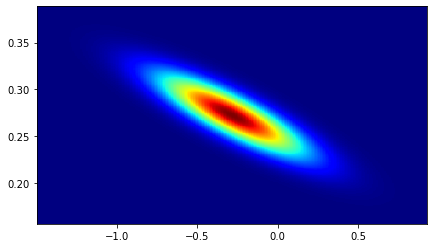

In [39]:
plot_heatmap(nu_posterior_2[:2], sigma_posterior_2[:2,:2])

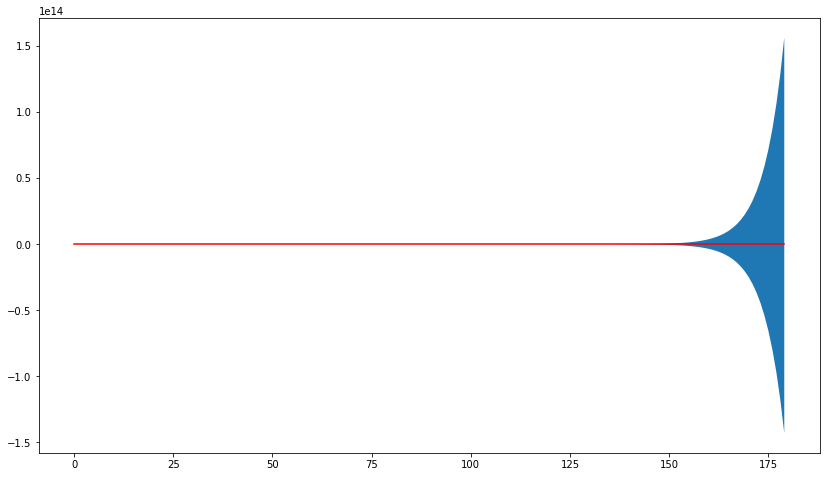

In [40]:
y_2 = sample_predictions(create_x_array_2(180), nu_posterior_2, sigma_posterior_2, n=500)
plot_dist(create_x_array_2(180), y_2, nu_posterior_2, sigma_posterior_2)

#### Слишком мелкий масшатаб. Пострим распределение с 80го по 90го день.

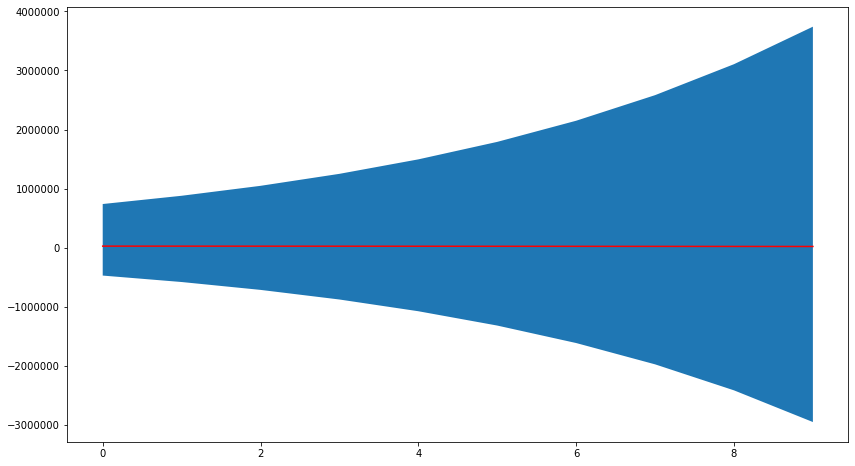

In [41]:
plot_dist(create_x_array_2(180)[80:90], y_2[:,80:90], nu_posterior_2, sigma_posterior_2)

#### Такая большая дисперсия вызвана тем, что мы используем квадратичную функцую, которая ещё и является степенью экспоненты. При сэмлировании иногда возникают такие параметры, которые приводят выбросам (большим значениям). Попробуем избавится от них, отбросив верхние и нижние перцентили

In [42]:
def plot_dist_percentiled(x, y, nu, sigma, low_percent=5, high_percent=95, plot_variance=True):
    plt.figure(figsize=(14,8))
    plt.plot(range(len(x)), np.exp(np.matmul(x, nu)), color='red')
    y_new = []
    for i in range(y.shape[1]):
        cur_preds = y[:,i]
        low_thresh = np.percentile(cur_preds, low_percent)
        high_thresh = np.percentile(cur_preds, high_percent)
        cur_preds = cur_preds[cur_preds>low_thresh]
        cur_preds = cur_preds[cur_preds<high_thresh]
        y_new.append(cur_preds)
    if plot_variance:
        plt.fill_between(range(len(x)), np.mean(y_new, axis=1)+np.std(y_new, axis=1), np.mean(y_new, axis=1)-np.std(y_new, axis=1))

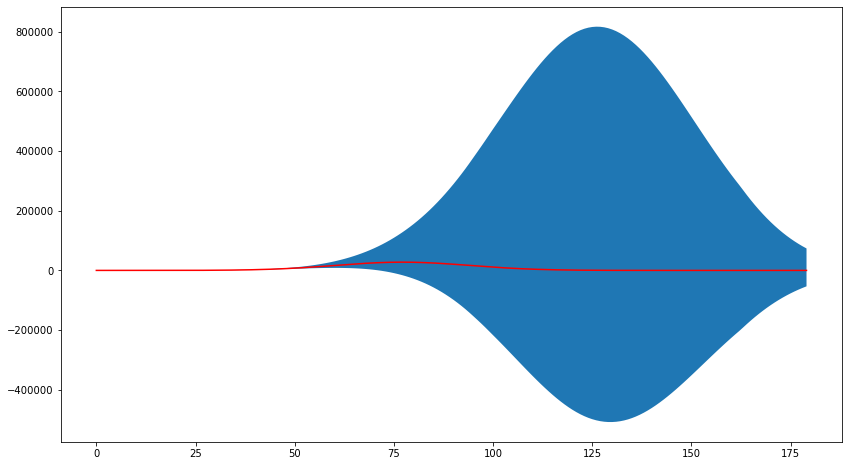

In [43]:
plot_dist_percentiled(create_x_array_2(180), y_2, nu_posterior_2, sigma_posterior_2, low_percent=5, high_percent=95)

In [44]:
print("Оптимистичный план:")
percent=10
print("Случаев болезни 1 мая: ", int(np.sum(np.percentile(y_2[:,:may1],percent, axis=0))))
print("Случаев болезни 1 июня: ", int(np.sum(np.percentile(y_2[:,:jun1],percent, axis=0))))
print("Случаев болезни 1 сентября: ", int(np.sum(np.percentile(y_2[:,:sep1],percent, axis=0))))

Оптимистичный план:
Случаев болезни 1 мая:  83476
Случаев болезни 1 июня:  226641
Случаев болезни 1 сентября:  235109


In [45]:
print("Пессиместичный план:")
percent=90
print("Случаев болезни 1 мая: ", int(np.sum(np.percentile(y_2[:,:may1],percent, axis=0))))
print("Случаев болезни 1 июня: ", int(np.sum(np.percentile(y_2[:,:jun1],percent, axis=0))))
print("Случаев болезни 1 сентября: ", int(np.sum(np.percentile(y_2[:,:sep1],percent, axis=0))))

Пессиместичный план:
Случаев болезни 1 мая:  210354
Случаев болезни 1 июня:  5592005
Случаев болезни 1 сентября:  39920874


#### Повторим моделирование для США

##### В некоторых страннах в первые дни статистика могла собираться/даваться не совсем точно, поэтому в те дни, когда кол-во зараженных равно 0 мы заберём их со следующих k дней. Хороший пример есть в данных по Беларуси, когда два дня кол-во было 0, а потом стало в 3 раза больше, чем обычно. 

In [46]:
def smooth(x, window_size=3):
    x = x.copy()
    for i in range(len(x)-window_size+1):
        if x[i] == 0:
            total = sum(x[i:i+window_size])
            for j in range(window_size):
                x[i+j] = total/window_size
    return x

In [47]:
data_usa = data[data.location=='United States']
data_usa = data_usa[data_usa.date >= datetime(2020,2,19)]

In [48]:
total_cases_usa = np.array(data_usa.total_cases)
new_cases_usa = np.array(data_usa.new_cases)
new_cases_usa = smooth(new_cases_usa, window_size=5)

In [49]:
print(new_cases_usa)

[    4     4     4     4     4     5     5     5     5     5     6     3
    20    14    22    34    74   105    95   121   200   271   287   351
   511   777   823   887  1766  2988  4835  5374  7123  8459 11236  8789
 13963 16797 18695 19979 18360 21595 24998 27103 28819 32425 34272 25398
 30561 30613 33323 33901 35527 28391 27620 25023 26922 30148 31667 30833
 32922 24601 28065 37289 17588 26543 21352 48529 26857 22541 24132 27326
 29917 33955 29288 24972 22593 23841 24128]


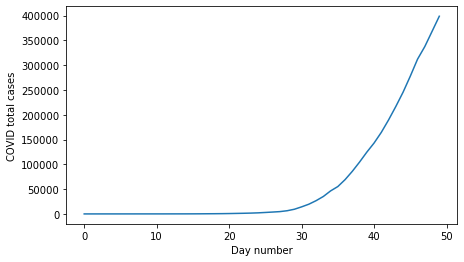

In [50]:
plt.figure(figsize=(7,4))
plt.plot(range(train_russia_days), total_cases_usa[train_idx])
plt.xlabel("Day number")
plt.ylabel("COVID total cases")
plt.show()

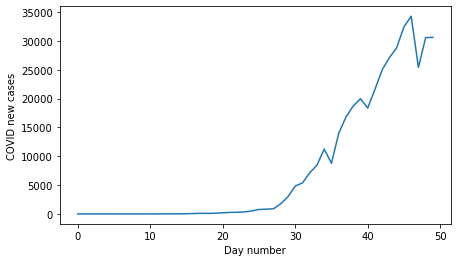

In [51]:
plt.figure(figsize=(7,4))
plt.plot(range(train_russia_days), new_cases_usa[train_idx])
plt.xlabel("Day number")
plt.ylabel("COVID new cases")
plt.show()

In [52]:
new_cases_usa_log = np.log(new_cases_usa)

In [53]:
model3 = Ridge()
model3.fit(x_train_2, new_cases_usa_log[:train_russia_days])
print(model3.coef_)

[ 0.          0.2980444  -0.00136675]


In [54]:
noise_variance_usa = np.sum(np.power(new_cases_usa_log[train_idx] - model3.predict(x_train_2),2))/train_russia_days
print(noise_variance_usa)
nu_posterior_usa, sigma_posterior_usa = calc_posterior(x_train_2, new_cases_usa_log[:train_russia_days], nu_prior_2, sigma_prior_2, noise_variance_usa)
print(nu_posterior_usa)
print (sigma_posterior_usa)

0.4036095445998869
[-0.0527865   0.29802151 -0.00136696]
[[ 6.28850240e-02 -5.07994185e-03  8.55140660e-05]
 [-5.07994185e-03  5.70167477e-04 -1.09439147e-05]
 [ 8.55140660e-05 -1.09439147e-05  2.25011205e-07]]


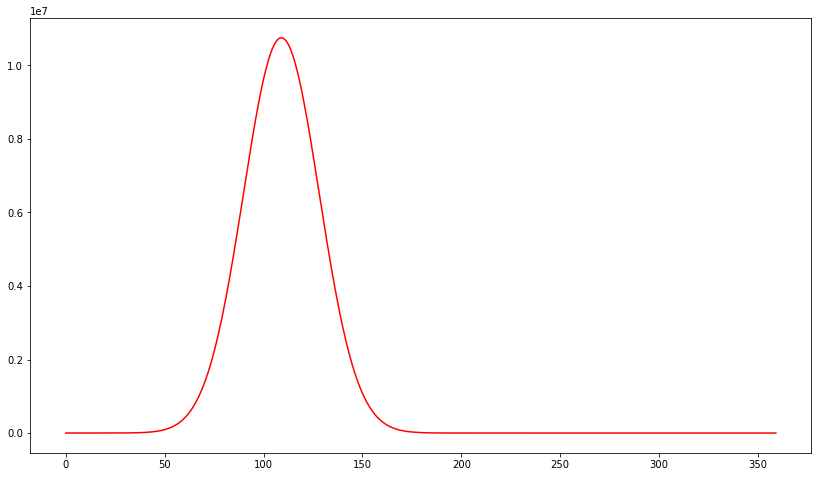

In [55]:
y_usa = sample_predictions(create_x_array_2(360), nu_posterior_usa, sigma_posterior_usa, n=500)
plot_dist_percentiled(create_x_array_2(360), y_usa, nu_posterior_usa, sigma_posterior_usa, low_percent=15, high_percent=85, plot_variance=False)

In [56]:
print("Оптимистичный план:")
percent=10
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_usa[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_usa[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_usa[:,:360],percent, axis=0))))

Оптимистичный план:
Случаев болезни 90 дней:  14384638
Случаев болезни 180 дней:  22315129
Случаев болезни 360 дней:  22315129


In [57]:
print("Пессиместичный план:")
percent=90
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_usa[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_usa[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_usa[:,:360],percent, axis=0))))

Пессиместичный план:
Случаев болезни 90 дней:  594986535
Случаев болезни 180 дней:  863614757524
Случаев болезни 360 дней:  1507130861703


#### Для Беларуси

In [58]:
data_belarus = data[data.location=='Belarus']
data_belarus = data_belarus[data_belarus.date >= datetime(2020,3,4)]

In [59]:
total_cases_belarus = np.array(data_belarus.total_cases)
new_cases_belarus = np.array(data_belarus.new_cases)

In [60]:
print(new_cases_belarus)

[   3    2    3    3    9    6    9    0   10   11    0   19    0    5
    0    5    0    8    0    0   11   47    0  102   97   43  170  136
  161  205  420  495  245  352  341  362  447  476  575    0    0 1485
  459  558  741  751  817  873  826  919  973  846  890  911  877  784
  861  905]


In [61]:
new_cases_belarus = smooth(new_cases_belarus, window_size=10)
#Пришлось делать такое широкое окно, т.к. первое время Беларусь давала не очень хорошую статистику

In [62]:
new_cases_belarus

array([  3,   2,   3,   3,   9,   6,   9,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   8,  60,  60,  60,  60,  60,  60,  60,  60,
        60,  60, 161, 205, 420, 495, 245, 352, 341, 362, 447, 476, 575,
       651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 919, 973, 846,
       890, 911, 877, 784, 861, 905], dtype=int64)

In [63]:
new_cases_belarus_log = np.log(new_cases_belarus)

In [64]:
new_cases_belarus_log

array([1.09861229, 0.69314718, 1.09861229, 1.09861229, 2.19722458,
       1.79175947, 2.19722458, 1.60943791, 1.60943791, 1.60943791,
       1.60943791, 1.60943791, 1.60943791, 1.60943791, 1.60943791,
       1.60943791, 1.60943791, 2.07944154, 4.09434456, 4.09434456,
       4.09434456, 4.09434456, 4.09434456, 4.09434456, 4.09434456,
       4.09434456, 4.09434456, 4.09434456, 5.08140436, 5.32300998,
       6.04025471, 6.20455776, 5.50125821, 5.86363118, 5.83188248,
       5.89164421, 6.10255859, 6.16541785, 6.35437004, 6.47850964,
       6.47850964, 6.47850964, 6.47850964, 6.47850964, 6.47850964,
       6.47850964, 6.47850964, 6.47850964, 6.47850964, 6.82328612,
       6.88038408, 6.74051936, 6.79122146, 6.8145429 , 6.77650699,
       6.66440902, 6.7580945 , 6.80793494])

In [65]:
model4 = Ridge()
model4.fit(x_train_2, new_cases_belarus_log[:train_russia_days])
print(model4.coef_)

[ 0.          0.17557677 -0.00076925]


In [66]:
np.exp(model4.predict([[1,1720,1720**2]]))

array([0.])

In [67]:
noise_variance_belarus = np.sum(np.power(new_cases_belarus_log[train_idx] - model4.predict(x_train_2),2))/train_russia_days
print(noise_variance_belarus)
nu_posterior_belarus, sigma_posterior_belarus = calc_posterior(x_train_2, new_cases_belarus_log[:train_russia_days], nu_prior_2, sigma_prior_2, noise_variance_belarus)
print(nu_posterior_belarus)
print (sigma_posterior_belarus)

0.35093551504363524
[ 0.40061564  0.17763396 -0.00080426]
[[ 5.51334954e-02 -4.45385526e-03  7.49755134e-05]
 [-4.45385526e-03  4.98746304e-04 -9.56607157e-06]
 [ 7.49755134e-05 -9.56607157e-06  1.96495991e-07]]


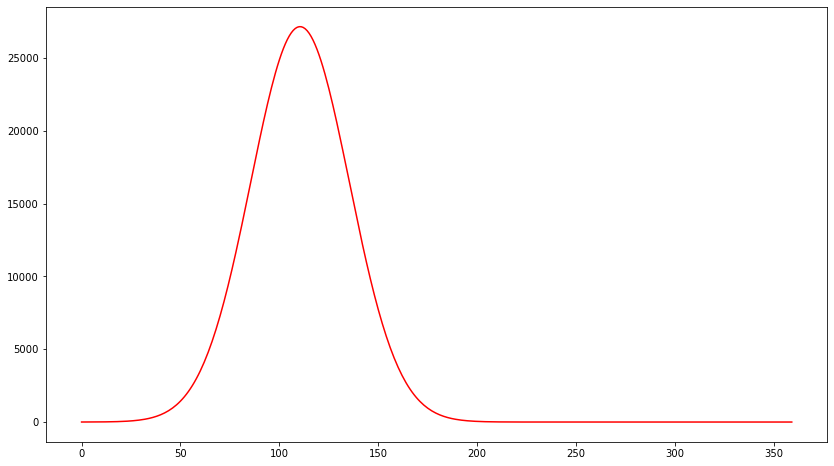

In [68]:
y_belarus = sample_predictions(create_x_array_2(360), nu_posterior_belarus, sigma_posterior_belarus, n=500)
plot_dist_percentiled(create_x_array_2(360), y_belarus, nu_posterior_belarus, sigma_posterior_belarus, low_percent=15, high_percent=85, plot_variance=False)

In [69]:
print("Оптимистичный план:")
percent=10
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_belarus[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_belarus[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_belarus[:,:360],percent, axis=0))))

Оптимистичный план:
Случаев болезни 90 дней:  94660
Случаев болезни 180 дней:  123629
Случаев болезни 360 дней:  123629


In [70]:
print("Пессиместичный план:")
percent=90
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_belarus[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_belarus[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_belarus[:,:360],percent, axis=0))))

Пессиместичный план:
Случаев болезни 90 дней:  2016010
Случаев болезни 180 дней:  12245046857
Случаев болезни 360 дней:  35001071312774


#### Италия

In [71]:
data_italy = data[data.location=='Italy']
data_italy = data_italy[data_italy.date >= datetime(2020,2,22)]

In [72]:
total_cases_italy = np.array(data_italy.total_cases)
new_cases_italy = np.array(data_italy.new_cases)

In [73]:
print(new_cases_italy)

[  14   62   53   97   93   78  250  238  240  561  347  466  587  769
  778 1247 1492 1797  977 2313 2651 2547 3497 2823 4000 3526 4207 5322
 5986 6557 5560 4789 5249 5210 6153 5959 5974 5217 4050 4053 4782 4668
 4585 4805 4316 3599 3039 3836 4204 3951 4694 4092 3153 2972 2667 3786
 3493 3491 3047 2256 2729 3370 2646 3021 2357 2324 1739 2091 2086 1872
 1965 1900 1389 1221 1075 1444]


In [74]:
new_cases_italy_log = np.log(new_cases_italy)

In [75]:
model5 = Ridge()
model5.fit(x_train_2, new_cases_italy_log[:train_russia_days])
print(model5.coef_)

[ 0.          0.29846804 -0.00424095]


In [76]:
noise_variance_italy = np.sum(np.power(new_cases_italy_log[train_idx] - model4.predict(x_train_2),2))/train_russia_days
print(noise_variance_italy)
nu_posterior_italy, sigma_posterior_italy = calc_posterior(x_train_2, new_cases_italy_log[:train_russia_days], nu_prior_2, sigma_prior_2, noise_variance_italy)
print(nu_posterior_italy)
print (sigma_posterior_italy)

11.37274571128673
[ 1.21722713  0.47690902 -0.0072279 ]
[[ 6.51410697e-01 -5.23942371e-02  8.80069837e-04]
 [-5.23942371e-02  8.69753801e-03 -1.84017461e-04]
 [ 8.80069837e-04 -1.84017461e-04  4.24017533e-06]]


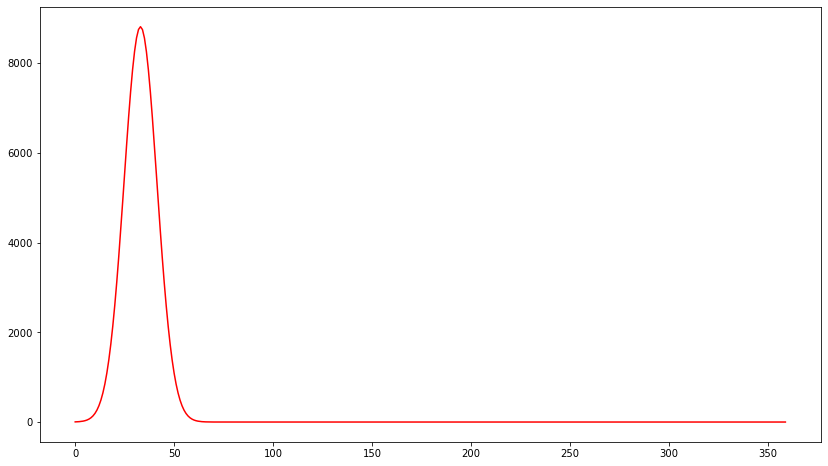

In [77]:
y_italy = sample_predictions(create_x_array_2(360), nu_posterior_italy, sigma_posterior_italy, n=500)
plot_dist_percentiled(create_x_array_2(360), y_italy, nu_posterior_italy, sigma_posterior_italy, low_percent=15, high_percent=85, plot_variance=False)

In [78]:
print("Оптимистичный план:")
percent=10
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_italy[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_italy[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_italy[:,:360],percent, axis=0))))

Оптимистичный план:
Случаев болезни 90 дней:  73828
Случаев болезни 180 дней:  73828
Случаев болезни 360 дней:  73828


In [79]:
print("Пессиместичный план:")
percent=90
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_italy[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_italy[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_italy[:,:360],percent, axis=0))))

Пессиместичный план:
Случаев болезни 90 дней:  495698
Случаев болезни 180 дней:  495698
Случаев болезни 360 дней:  495698


#### Чехия

In [80]:
data_czech = data[data.location=='Czech Republic']
data_czech = data_czech[data_czech.date >= datetime(2020,3,2)]

In [81]:
total_cases_czech = np.array(data_czech.total_cases)
new_cases_czech = np.array(data_czech.new_cases)

In [82]:
new_cases_czech = smooth(new_cases_czech)

In [83]:
print(new_cases_czech)

[  3   2   2   2   2   7   7   6   8  23  31  22  34  64  84  46  90  88
 172 210  91 170  71 158 260 408 217 384 166 173 306 281 269 332 282 115
 235 195 295 257 163 170  89  68  82 162 130 116 105 133 127 127  95  52
  85  79  52  45  55  75 103  55  18  26  38  77  78]


In [84]:
new_cases_czech_log = np.log(new_cases_czech)

In [85]:
model6 = Ridge()
model6.fit(x_train_2, new_cases_czech_log[:train_russia_days])
print(model6.coef_)

[ 0.          0.3295199  -0.00509741]


In [86]:
noise_variance_czech = np.sum(np.power(new_cases_czech_log[train_idx] - model4.predict(x_train_2),2))/train_russia_days
print(noise_variance_czech)
nu_posterior_czech, sigma_posterior_czech = calc_posterior(x_train_2, new_cases_czech_log[:train_russia_days], nu_prior_2, sigma_prior_2, noise_variance_czech)
print(nu_posterior_czech)
print (sigma_posterior_czech)

1.548359827300666
[ 0.22412846  0.33390573 -0.00517062]
[[ 2.04527240e-01 -1.65145136e-02  2.77936802e-04]
 [-1.65145136e-02  1.94623090e-03 -3.79180398e-05]
 [ 2.77936802e-04 -3.79180398e-05  7.94617501e-07]]


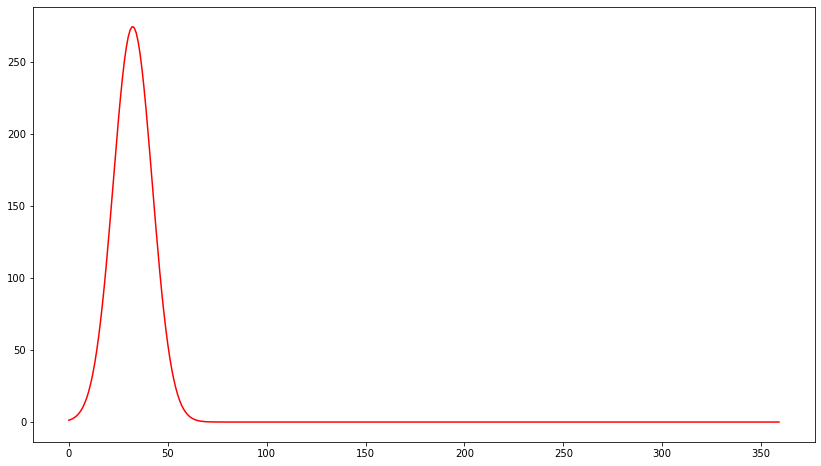

In [87]:
y_czech = sample_predictions(create_x_array_2(360), nu_posterior_czech, sigma_posterior_czech, n=500)
plot_dist_percentiled(create_x_array_2(360), y_czech, nu_posterior_czech, sigma_posterior_czech, low_percent=15, high_percent=85, plot_variance=False)

In [88]:
print("Оптимистичный план:")
percent=10
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_czech[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_czech[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_czech[:,:360],percent, axis=0))))

Оптимистичный план:
Случаев болезни 90 дней:  4722
Случаев болезни 180 дней:  4722
Случаев болезни 360 дней:  4722


In [89]:
print("Пессиместичный план:")
percent=90
print("Случаев болезни 90 дней: ", int(np.sum(np.percentile(y_czech[:,:90],percent, axis=0))))
print("Случаев болезни 180 дней: ", int(np.sum(np.percentile(y_czech[:,:180],percent, axis=0))))
print("Случаев болезни 360 дней: ", int(np.sum(np.percentile(y_czech[:,:360],percent, axis=0))))

Пессиместичный план:
Случаев болезни 90 дней:  9915
Случаев болезни 180 дней:  9915
Случаев болезни 360 дней:  9915


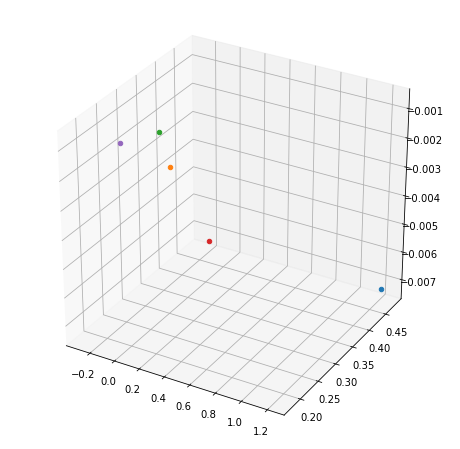

In [90]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(nu_posterior_italy[0], nu_posterior_italy[1],nu_posterior_italy[2], marker='o', label='Italy')
ax.scatter(nu_posterior_belarus[0], nu_posterior_belarus[1],nu_posterior_belarus[2], marker='o', label='Belarus')
ax.scatter(nu_posterior_usa[0], nu_posterior_usa[1],nu_posterior_usa[2], marker='o', label='USA')
ax.scatter(nu_posterior_czech[0], nu_posterior_czech[1],nu_posterior_czech[2], marker='o', label='Czech')
ax.scatter(nu_posterior_2[0], nu_posterior_2[1], nu_posterior_2[2], marker='o', label='Russia')
#ax.legend()
plt.show()

#### Можно предположить, что страны можно разделить на кластера по коэффециенту перед квадратом, т.к. он влияет на кол-во больных в перспективе. У стран с жёстким карантином(Чехия, Италия) он ниже, чем в странах без карантина, либо не строгим (Россия, Беларусь, США). Но это лишь предположение, проверять его нужно на значительно большим количестве стран.

Выводы: из данного упражнения я понял, что распростронение коронавируса можно моделировать :) Решение о карантине можно попробовать принимать на основе динамики роста в будущем (смотреть на кол-во больных в будущем, либо как-то оценивать по параметрам и т.д.)